# Tutorial: Resource estimation with PyGSLIB

This tutorial will guide you on doing resource estimation with PyGSLIB. The informing data is from the [BABBITT zone of the KEWEENAWAN DULUTH COMPLEX](http://www.nrri.umn.edu/egg/REPORTS/TR200321/TR200321.html).

The sequence of data preparation and estimation used in this example is as it follows:

-	import drillhole tables 
-	create a drillhole object
-	composite drillhole intervals
-	desurvey drillholes
-	code drillholes with domains
-	declustering and basic statistics
-	create a block model object
-	populate a wireframe domain with blocks
-	estimate with ordinary kriging, inverse of the power of the distance, and nearest neighbour
-	basic model validation

To run this demo in your computer download the [the demo files](https://github.com/opengeostat/pygslib/tree/master/pygslib/Ipython_templates/Tutorial_1).

In this tutorial we will use the development version (with commits of Oct 16, 2017 in the github repo). You will have to install pygslib by compiling the source code. 

```shell
git clone https://github.com/opengeostat/pygslib.git
cd pygslib
python setup.py develop
```

We recommend installing the conda package first [using this tutorial](https://www.youtube.com/watch?v=cbWXi7BfZVg) and then installing the development version, this will updeate some dependencies. In windows you will also need to install Microsoft Visual C++ Compiler for Python 2.7, availiable at https://www.microsoft.com/en-ca/download/details.aspx?id=44266, MinGW and libpython. To install the last two libraries in conda type the commands: 

```shell
c:\>conda install MinGW
c:\>conda install libpython
```
 
 
## Preliminaries
To follow this tutorial you may be familiar with: 

 - Python 2.7
 - Python Data Analysis Library (Pandas). PyGSLIB was designed to work with Pandas. 
 - Numpy
 - Matplotlib
 - Paraview, an open-source, multi-platform data analysis and visualization application
 - GSLIB, geostatistics and mineral resource estimation
 


## Loading python packages

In [1]:
# import third party python libraries
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
# make plots inline
%matplotlib inline

# later try %matplotlib notebook
#%matplotlib notebook


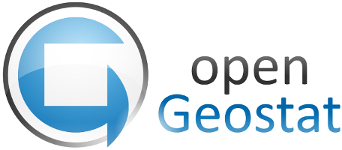

In [2]:
# import pygslib
import pygslib

Need some help? Just type


```
help(pygslib)
```

There is also an online manual at https://opengeostat.github.io/pygslib/ but is not updated

## Loading the drillhole tables
PyGSLIB requires drillholes tables loaded into Pandas DataFrames. Two tables are compulsory:
 - the collar, with the compulsory fields *BHID*, *XCOLLAR*, *YCOLLAR* and *ZCOLLAR* and the optional field *LENGTH*
 - and survey, with the compulsory fields *BHID*, *AT*, *AZ*, *DIP*

In addition, you may have any number of optional interval tables with the compulsory fields *BHID*, *FROM* and *TO*

In [3]:
# importing drillhole tables into pandas dataframes
collar = pd.read_csv('Babbitt/collar_BABBITT.csv')
survey = pd.read_csv('Babbitt/survey_BABBITT.csv')
assay = pd.read_csv('Babbitt/assay_BABBITT.csv')

In [4]:
# print first 3 lines of the table collar
collar.head(4)

,BHID,XCOLLAR,YCOLLAR,ZCOLLAR
0,34873,2296021.09,414095.85,1590.0
1,B1-001,2294148.20,420495.90,1620.9
2,B1-002,2296769.50,422333.50,1553.0
3,B1-003,2297820.11,423647.40,1565.0


In [5]:
# print first 3 lines of the table survey
survey.head(3)

,BHID,AT,AZ,DIP
0,34873,0.0,0,90.0
1,B1-001,0.0,327,60.0
2,B1-002,0.0,327,60.0


In [6]:
# print first 3 lines of the table assay
assay.head(3)

,BHID,FROM,TO,CU,NI,S,FE
0,34873,0.0,2515.0,NaN,NaN,NaN,NaN
1,34873,2515.0,2517.4,0.03,0.08,NaN,NaN
2,34873,2517.4,2518.9,0.04,0.10,NaN,NaN


Pandas provides a large set of functions to modify your data. Let's remove some columns and make non-assayed intervals equal to zero.

In [7]:
# droping some columns
assay.drop(['NI','S','FE'], axis=1, inplace=True)

# making non-sampled intervals equal to zero
assay.loc[~np.isfinite(assay['CU']), 'CU']=0

## Creating a drillhole object
To get access to the drillhole functions implemented in PyGSLIB, such as desurvey and compositing, you need to create a drillhole object (an instance of the class ``Drillhole``, defined on the submodule ``gslib.drillhole``)

In [8]:
#creating a drillhole object
mydholedb=pygslib.drillhole.Drillhole(collar=collar, survey=survey)

# now you can add as many interval tables as you want, for example, assays, lithology and RQD.
mydholedb.addtable(assay, 'assay', overwrite = False)


C:\Users\AMartinez\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: ! Collar table without LENGTH field
  


The output above is a warning message. This one is a complain because the field ``LENGTH`` was not included in the collar table. You will see similar warnings any time PyGSLIB detects a potential issue in your data.

In [9]:
# validating a drillhole object
mydholedb.validate()

C:\Users\AMartinez\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: ! survey with one value at BHID: 34873. This will produce error at desurvey
  
C:\Users\AMartinez\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: ! survey with one value at BHID: B1-001. This will produce error at desurvey
  


The warning above is serious. There are drillholes with only one survey record and to desurvey we need at least two records, the first one may be at the collar of the drillhole.

In [10]:
# fixing the issue of single interval at survey table
mydholedb.fix_survey_one_interval_err(90000.)

Note: To validate interval tables you may use the function ``validate_table``.

In [11]:
#validating interval tables
mydholedb.validate_table('assay')

## Compositing

Before doing any statistical or geostatistical analysis you may verify that all samples have approximately the same length. If samples have different lengths you may composite the drillhole intervals using a compositing algorithm.

The Length Mode is: 10.0


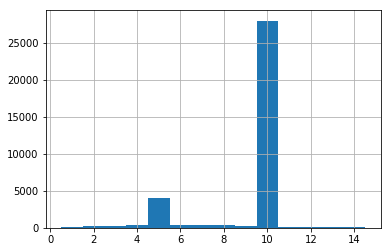

In [12]:
# Calculating length of sample intervals
mydholedb.table['assay']['Length']= mydholedb.table['assay']['TO']-mydholedb.table['assay']['FROM']

# plotting the interval lengths
mydholedb.table['assay']['Length'].hist(bins=np.arange(15)+0.5)

# printing length mode
print 'The Length Mode is:', mydholedb.table['assay']['Length'].mode()[0]


Most samples (the mode) are 10 ft length. This value or any of its multiples are good options for composite length, they minimize the oversplitting of sample intervals.

In [13]:
# compositing 
mydholedb.downh_composite('assay', variable_name= "CU", new_table_name= "CMP", 
                          cint = 10, minlen=-1, overwrite = True)

In [14]:
# first 5 rows of a table
mydholedb.table["CMP"].tail(5)

,BHID,CU,FROM,TO,_acum,_len
54184,RMC-66313,0.0,970.0,980.0,0.0,10.0
54185,RMC-66313,0.0,980.0,990.0,0.0,10.0
54186,RMC-66313,0.0,990.0,1000.0,0.0,10.0
54187,RMC-66313,0.0,1000.0,1010.0,0.0,10.0
54188,RMC-66313,0.0,1010.0,1020.0,0.0,7.0


Note that some especial fields were created, those fields have prefix ``_``. ``_acum`` is the grade accumulated in the composite interval (sum of grades from sample intervals contributing to the composite interval) and ``_len`` is the actual length of the composite.

In the table CMP the interval at row 54188 has *FROM : 1010.0 and TO: 1020.0* but the sample length is only *7.0 ft*. In this way the *FROM* and *TO* intervals of any drillhole or table are always at the same position and you can safely use the fields *[BHID, FROM]* to merge tables.


## Desurveying

To plot drillholes in 3D or to estimate grade values you need to calculate the coordinates of the composites. This process is known as *desurvey*. There are many techniques to desurvey, PyGSLIB uses minimum curvature.

Desurvey will add the fields ``azm, dipm`` and ``xm, ym, zm``, these are directions and the coordinates at the mid point of composite intervals. You have the option to add endpoint coordinates ``xb, yb, zb`` and ``xe, ye, ze``, these are required to export drillholes in vtk format.


In [15]:
# desurveying an interval table
mydholedb.desurvey('CMP',warns=False, endpoints=True)

# first 3 rows of a table
mydholedb.table["CMP"].head(3)

,BHID,CU,FROM,TO,_acum,_len,azmm,dipm,xm,ym,...,azmb,dipb,xb,yb,zb,azme,dipe,xe,ye,ze
0,34873,0.0,0.0,10.0,0.0,10.0,0.0,90.0,2296021.09,414095.85,...,0.0,90.0,2296021.09,414095.85,1590.0,0.0,90.0,2296021.09,414095.85,1580.0
1,34873,0.0,10.0,20.0,0.0,10.0,0.0,90.0,2296021.09,414095.85,...,0.0,90.0,2296021.09,414095.85,1580.0,0.0,90.0,2296021.09,414095.85,1570.0
2,34873,0.0,20.0,30.0,0.0,10.0,0.0,90.0,2296021.09,414095.85,...,0.0,90.0,2296021.09,414095.85,1570.0,0.0,90.0,2296021.09,414095.85,1560.0


## Createing a BHID of type integer

The compiled FORTRAN code of GSLIB is not good with data of type *str*, sometimes you need to transform the *BHID* to type *int*, for example, if you use a maximum number of samples per drillholes on kriging or calculating downhole variograms. The function ``txt2intID`` will do this work for you.

In [16]:
# creating BHID of type integer
mydholedb.txt2intID('CMP')

# first 3 rows of a subtable
mydholedb.table["CMP"][['BHID', 'BHIDint', 'FROM', 'TO']].tail(3)

,BHID,BHIDint,FROM,TO
54186,RMC-66313,399,990.0,1000.0
54187,RMC-66313,399,1000.0,1010.0
54188,RMC-66313,399,1010.0,1020.0


## Rendering drillhole intervals in Paraview and exporting drillhole data

PyGSLIB can export drillhole intervals to VTK. Drag and drop the VTK file on Paraview to see the drillholes in 3D. For a better image quality add a *tube* filter and update the color scale.

In [17]:
# exporting results to VTK
mydholedb.export_core_vtk_line('CMP', 'cmp.vtk', title = 'Drillhole created in PyGSLIB')

This is how it looks in Paraview

![](figure1.JPG "Drillhole 3D view" )

Interval tables are stored as a python dictionary of *{Table Name : Pandas Dataframes}*. To export data to \*.csv format use the Pandas function ``Dataframe.to_csv``. You can also export to any other format supported by Pandas, [this is the list of formats supported](http://pandas.pydata.org/pandas-docs/stable/io.html).


In [18]:
# inspecting interval tables in drillhole object
print "Table names ", mydholedb.table_mames
print "Tables names", mydholedb.table.keys() 
print "table is    ", type(mydholedb.table)

Table names  ['assay', 'CMP']
Tables names ['assay', 'CMP']
table is     <type 'dict'>


In [19]:
# exporting to csv
mydholedb.table["CMP"].to_csv('cmp.csv', index=False)

## Tagging samples with domain code

Use the function ``pygslib.vtktools.pointinsolid`` to label composites in a domain defined by a closed wireframe. You can also use this function to label samples in open surfaces (ej. between two surfaces), below a surface and above a surface.


In [20]:
# importing the a wireframe (this one was created with https://geomodelr.com)
domain=pygslib.vtktools.loadSTL('Babbitt/Mpz.stl')

Only Stereo Lithography (*.STL) and XML VTK Polydata (VTP) file formats are implemented. If your data is in a different format, ej. DXF, you can use a file format converter, my favorite is [meshconv](http://www.patrickmin.com/meshconv)

In [21]:
# creating array to tag samples in domain1
inside1=pygslib.vtktools.pointinsolid(domain, 
                       x=mydholedb.table['CMP']['xm'].values, 
                       y=mydholedb.table['CMP']['ym'].values, 
                       z=mydholedb.table['CMP']['zm'].values)

# creating a new domain field 
mydholedb.table['CMP']['Domain']=inside1.astype(int)

# first 3 rows of a subtable
mydholedb.table['CMP'][['BHID', 'FROM', 'TO', 'Domain']].head(3)

,BHID,FROM,TO,Domain
0,34873,0.0,10.0,0
1,34873,10.0,20.0,0
2,34873,20.0,30.0,0


In [22]:
# exporting results to VTK
mydholedb.export_core_vtk_line('CMP', 'cmp.vtk',  title = 'Generated with PyGSLIB')

# exporting to csv
mydholedb.table["CMP"].to_csv('cmp.csv', index=False)

A section of the wireframe and the drillholes may look as follows

![](figure2.JPG "Drillhole tagging" )

## Block modeling


Cu grades will be estimated on blocks inside the mineralized domain. To create those blocks you may:

 - create a block model object ``pygslib.blockmodel.Blockmodel``
 - fill the mineralized domain with blocks
 
In PyGSLIB we use percent blocks, similar to GEMS &reg;. In the future we will implement subcell style, similar to Surpac &reg;, using Adaptive Mesh Refinement (AMR).

Blocks are stored in the class member ``bmtable``, this is a Pandas DataFrame with especial field index ``IJK`` or ``[IX,IY,IZ]`` and coordinates ``[XC, YC, ZC]``. We use GSLIB order, in other words, ``IJK`` is the equivalent of the row number in a GSLIB grid.

Block model tables can be full or partial (with some missing blocks). Only one table will be available in a block model object.

The block model definition is stored in the members ``nx, ny, nz, xorg, yorg, zorg, dx, dy, dz``. The origin ``xorg, yorg, zorg`` refers to the lower left corner of the lower left block (not the centroid), like in Datamine Studio &reg;.

In [23]:
# The model definition
xorg = 2288230
yorg = 415200
zorg = -1000
dx = 100
dy = 100
dz = 30
nx = 160
ny = 100
nz = 90

In [24]:
# Creating an empty block model
mymodel=pygslib.blockmodel.Blockmodel(nx,ny,nz,xorg,yorg,zorg,dx,dy,dz)

In [25]:
# filling wireframe with blocks
mymodel.fillwireframe(domain)

# the fillwireframe function generates a field named  __in, 
# this is the proportion inside the wireframe. Here we rename __in to D1
mymodel.bmtable.rename(columns={'__in': 'D1'},inplace=True)

In [26]:
# creating a partial model by filtering out blocks with zero proportion inside the solid
mymodel.set_blocks(mymodel.bmtable[mymodel.bmtable['D1']> 0])

# export partial model to a vtk unstructured grid (*.vtu)
mymodel.blocks2vtkUnstructuredGrid(path='model.vtu')

Note that ``fillwireframe`` created or overwrited ``mymodel.bmtable``. The blocks outside the wireframe where filtered out and the final output is a partial model with block inside or touching the wireframe domain.

Note that ``fillwireframe`` works with closed surfaces only. 

A section view of the blocks colored by percentage inside the solid and the wireframe (white lines) may look as follows:


![](figure3.JPG "block model percentage" )

## Some basic stats

You may spend some time doing exploratory data analysis, looking at statistical plots, 3D views and 2D sections of your data. A good comersial software for this is [Supervisor &reg;](http://opengeostat.com/software-solutions/), open source options are Pandas, [Statsmodels](http://statsmodels.sourceforge.net/), [Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) and [glueviz](http://glueviz.org/en/stable/).

PyGSLIB includes some minimum functionality for statistical plots and calculations, with support for declustering wight. Here we demonstrate how you can do a declustering analysis of the samples in the mineralized domain and how to evaluate the declustered mean. The declustered mean will be compared later with the mean of CU estimates.

Note: In this section we are not including all the statistical analysis usually required for resource estimation.

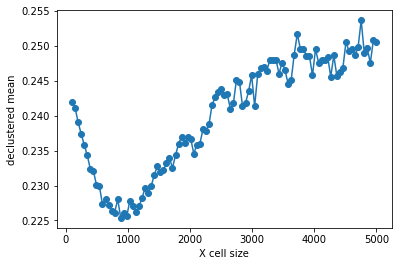

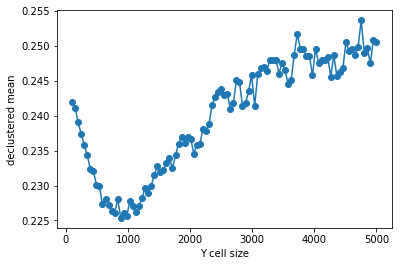

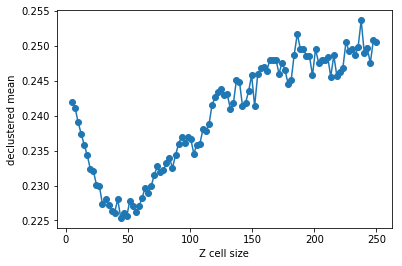

In [27]:
#declustering parameters 
parameters_declus = { 
        'x'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'xm'], 
        'y'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'ym'],  
        'z'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'zm'], 
        'vr'     :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'],   
        'anisy'  :  1.,       
        'anisz'  :  0.05,              
        'minmax' :  0,                 
        'ncell'  :  100,                  
        'cmin'   :  100., 
        'cmax'   :  5000.,                 
        'noff'   :  8,                    
        'maxcel' :  -1}               

# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

#Plotting declustering optimization results
plt.plot (rxcs, rvrcr, '-o')
plt.xlabel('X cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rycs, rvrcr, '-o')
plt.xlabel('Y cell size')
plt.ylabel('declustered mean')
plt.show()
plt.plot (rzcs, rvrcr, '-o')
plt.xlabel('Z cell size')
plt.ylabel('declustered mean')
plt.show()


In [28]:
# parameters for declustering with the cell size selected
parameters_declus = { 
        'x'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'xm'], 
        'y'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'ym'],  
        'z'      :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'zm'], 
        'vr'     :  mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'],  
        'anisy'  :  1.,    # y == x
        'anisz'  :  0.1,  # z = x/20     
        'minmax' :  0,                 
        'ncell'  :  1,                  
        'cmin'   :  1000., 
        'cmax'   :  1000.,                 
        'noff'   :  8,                    
        'maxcel' :  -1}  
 

# declustering 
wtopt,vrop,wtmin,wtmax,error, \
xinc,yinc,zinc,rxcs,rycs,rzcs,rvrcr = pygslib.gslib.declus(parameters_declus)

# Adding declustering weight to a drillhole interval table
mydholedb.table["CMP"]['declustwt'] = 1
mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'declustwt'] = wtopt

# calculating declustered mean
decl_mean = rvrcr[0]

Now we can calculate some declustered stats and plot declustered histogras

In [29]:
# prepare parameters dictionary
parameters = {
        'hmin' : None,                          #in/output rank-0 array(float,'d')
        'hmax' : None,                         #in/output rank-0 array(float,'d')
        'ncl'  : 30,                            #int, number of bins
        'iwt'  : 1,                             #int, 1 use declustering weight
        'ilog' : 1,                             #int, 1 use logscale
        'icum' : 0,                             #int, 1 use cumulative
        'va'   : mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'],             # array('d') with bounds (nd)
        'wt'   : mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'declustwt'],                          # array('d') with bounds (nd), wight variable (obtained with declust?)
        'figure' : None ,                       # a bokeh figure object (Optional: new figure created if None). Set none or undefined if creating a new figure. 
        'title'  : 'Hist Cu',                    # string. Figure title
        'xlabel' : 'Cu (%)', # string. X axis label 
        'ylabel' : 'f(%)', # string. Y axis label
        # visual parameter for the histogram
        'color' : 'red', # string with valid CSS colour (https://www.w3schools.com/colors/colors_names.asp), or an RGB(A) hex value, or tuple of integers (r,g,b), or tuple of (r,g,b,a) 
        'legend': 'Non - Declustered', # string (Optional, default "NA")
        'alpha' :  0.5, # float [0-1]. Transparency of the fill colour 
        'lwidth': 1, # float. Line width
        # legend 
        'legendloc': 'top_left'}

# calculate histogram
stats, fig = pygslib.plothtml.histgplt(parameters)

print 'CV', stats['xcvr']
print 'Mean', stats['xmen']
print 'Min', stats['xmin']
print 'Max', stats['xmax']


# show the figure
pygslib.plothtml.show(fig)

CV 1.47118900149
Mean 0.225190367247
Min 0.0
Max 15.4000001


In [30]:
# plot CDF 
parameters_probplt = {
    # gslib parameters for histogram calculation  
    'iwt'  : 1, # input boolean (Optional: set True). Use weight variable?
    'va'   : mydholedb.table["CMP"].loc[(mydholedb.table['CMP']['Domain']==1) & (mydholedb.table['CMP']['CU']>0), 'CU'],             # array('d') with bounds (nd)
    'wt'   : mydholedb.table["CMP"].loc[(mydholedb.table['CMP']['Domain']==1) & (mydholedb.table['CMP']['CU']>0), 'declustwt'],                          # array('d') with bounds (nd), wight variable (obtained with declust?)
    # visual parameters for figure (if a new figure is created)
    'figure' : None, # a bokeh figure object (Optional: new figure created if None). Set none or undefined if creating a new figure. 
    'title'  : 'Prob blot', # string (Optional, "Histogram"). Figure title
    'xlabel' : 'Cu', # string (Optional, default "Z"). X axis label 
    'ylabel' : 'P[Cu<c]', # string (Optional, default "f(%)"). Y axis label
    'xlog' : 1, # boolean (Optional, default True). If true plot X axis in log sale.
    'ylog' : 1, # boolean (Optional, default True). If true plot Y axis in log sale.            
    # visual parameter for the probplt
    'style' : 'cross', # string with valid bokeh chart type 
    'color' : 'blue', # string with valid CSS colour (https://www.w3schools.com/colors/colors_names.asp), or an RGB(A) hex value, or tuple of integers (r,g,b), or tuple of (r,g,b,a) (Optional, default "navy")
    'legend': 'Declustered Cu', # string (Optional, default "NA"). 
    'alpha' : 1, # float [0-1] (Optional, default 0.5). Transparency of the fill colour 
    'lwidth': 0, # float (Optional, default 1). Line width
    # leyend
    'legendloc': 'bottom_right'} #  float (Optional, default 'top_right'). Any of top_left, top_center, top_right, center_right, bottom_right, bottom_center, bottom_left, center_left or center

results, fig2 = pygslib.plothtml.probplt(parameters_probplt)
# show the plot
pygslib.plothtml.show(fig2)

In [31]:
results

{'binval': array([  1.35875964e-05,   4.50984100e-05,   2.94870422e-04, ...,
          9.99926438e-01,   9.99954949e-01,   9.99984753e-01]),
 'cl': array([  9.99999980e-04,   9.99999980e-04,   1.00000001e-03, ...,
          1.09999997e+01,   1.43499999e+01,   1.54000001e+01]),
 'error': 0,
 'xcvr': 0.9587717427220468,
 'xlqt': 0.1400000005,
 'xmax': 15.4000001,
 'xmed': 0.30100000042190583,
 'xmen': 0.30100000042190583,
 'xmin': 0.0009999999799999999,
 'xpt025': 0.014999999650000002,
 'xpt975': 1.0732820446853633,
 'xuqt': 0.525000006,
 'xvar': 0.12672198696392797}

## Variography

In [32]:
# TODO: 

## Estimating Cu grade in one block 

For estimation you may use the function ``pygslib.gslib.kt3d``, which is the GSLIB’s KT3D program modified and embedded into python. KT3D now includes a maximum number of samples per drillhole in the search ellipsoid and the estimation is only in the blocks provided as arrays. 

The input parameters of ``pygslib.gslib.kt3d`` are defined in a large and complicated dictionary. You can get this dictionary by typing 

```
print pygslib.gslib.kt3d.__doc__
```

Note that some parameters are optional. PyGSLIB will initialize those parameters to zero or to array of zeros, for example if you exclude the coordinate Z, PyGSLIB will create an array of zeros in its place.

To understand GSLIB’s KT3D parameters you may read the [GSLIB user manual](https://www.amazon.ca/GSLIB-Geostatistical-Software-Library-Users/dp/0195100158) or [the kt3d gslib program parameter documentation](http://www.statios.com/help/kt3d.html). 

Note that in PyGSLIB the parameters nx, ny and nz are only used by superblock search algorithm, if these parameters are arbitrary the output will be correct but the running time may be longer.


In [33]:
# creating parameter dictionary for estimation in one block
kt3d_Parameters = {
            # Input Data (Only using intervals in the mineralized domain)
            # ----------
            'x' : mydholedb.table["CMP"]['xm'][mydholedb.table["CMP"]['Domain']==1].values, 
            'y' : mydholedb.table["CMP"]['ym'][mydholedb.table["CMP"]['Domain']==1].values,
            'z' : mydholedb.table["CMP"]['zm'][mydholedb.table["CMP"]['Domain']==1].values,
            'vr' : mydholedb.table["CMP"]['CU'][mydholedb.table["CMP"]['Domain']==1].values,
            'bhid' : mydholedb.table["CMP"]['BHIDint'][mydholedb.table["CMP"]['Domain']==1].values, # an interger BHID
            # Output (Target) 
            # ----------
            'nx' : nx,  
            'ny' : ny,  
            'nz' : nz, 
            'xmn' : xorg,  
            'ymn' : yorg,  
            'zmn' : zorg,  
            'xsiz' : dx,  
            'ysiz' : dy,   
            'zsiz' : dz, 
            'nxdis' : 5,  
            'nydis' : 5,  
            'nzdis' : 3,  
            'outx' : mymodel.bmtable['XC'][mymodel.bmtable['IJK']==1149229].values,  # filter to estimate only on block with IJK 1149229
            'outy' : mymodel.bmtable['YC'][mymodel.bmtable['IJK']==1149229].values,
            'outz' : mymodel.bmtable['ZC'][mymodel.bmtable['IJK']==1149229].values,
            # Search parameters 
            # ----------
            'radius'     : 850,   
            'radius1'    : 850,   
            'radius2'    : 250,   
            'sang1'      : -28,  
            'sang2'      : 34,   
            'sang3'      : 7,   
            'ndmax'      : 12,    
            'ndmin'      : 4,  
            'noct'       : 0,
            'nbhid'      : 3,   
            # Kriging parameters and options 
            # ----------
            'ktype'      : 1,   # 1 Ordinary kriging 
            'idbg'       : 1,   # 0 no debug 
            # Variogram parameters 
            # ----------
            'c0'         : 0.35 * 0.109758094158,               # we require not normalized variance for GCOS, fix... multiply for actual variance
            'it'         : [2,2],    
            'cc'         : [0.41*0.109758094158,0.23*0.109758094158], 
            'aa'         : [96,1117],   
            'aa1'        : [96,1117],  
            'aa2'        : [96,300],   
            'ang1'       : [-28,-28],   
            'ang2'       : [ 34, 34],  
            'ang3'       : [  7,  7]}  

The variogram was calculated and modelled in a differnt software

The variogram types are as explained in http://www.gslib.com/gslib_help/vmtype.html, for example, ``'it' : [2,2] `` means two exponential models, in other words ``[Exponential 1,Exponential 2]`` 

Only the block with index *IJK* equal to 1149229 was used this time and ``'idbg'`` was set to one in order to get a full output of the last (and unique) block estimate, including the samples selected, kriging weight and the search ellipsoid. 

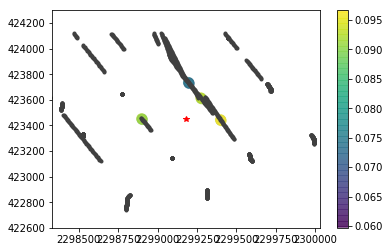

In [34]:
# estimating in one block
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)


In [35]:
#saving debug to a csv file using Pandas
pd.DataFrame({'x':debug['dbgxdat'],'y':debug['dbgydat'],'z':debug['dbgzdat'],'wt':debug['dbgwt']}).to_csv('dbg_data.csv', index=False)
#pd.DataFrame({'x':[debug['dbgxtg']],'y':[debug['dbgytg']],'z':[debug['dbgztg']],'na':[debug['na']]}).to_csv('dbg_target.csv', index=False)

# save the search ellipse to a VTK file
pygslib.vtktools.SavePolydata(debug['ellipsoid'], 'search_ellipsoid')

The results may look like this in Paraview. 

![](figure4.JPG "Ellipsoid")

In [36]:
# calculate block variance, wee need it for global change of support validation
# you can also calculate this with the function pygslib.gslib.block_covariance(...)
cbb=debug['cbb']

## Estimating in all blocks

After testing the estimation parameters in few blocks you may be ready to estimate in all the blocks within the mineralized domain. Just update the parameter file to remove the debug option and reassign the target coordinates as the actual blocks coordinate arrays.

In [37]:
# update parameter file
kt3d_Parameters['idbg'] = 0 # set the debug of
kt3d_Parameters['outx'] = mymodel.bmtable['XC'].values  # use all the blocks 
kt3d_Parameters['outy'] = mymodel.bmtable['YC'].values
kt3d_Parameters['outz'] = mymodel.bmtable['ZC'].values

In [38]:
# estimating in all blocks
estimate, debug, summary = pygslib.gslib.kt3d(kt3d_Parameters)

In [39]:
# adding the estimate into the model
mymodel.bmtable['CU_OK'] = estimate['outest']
mymodel.bmtable['CU_ID2'] = estimate['outidpower']
mymodel.bmtable['CU_NN'] = estimate['outnn']
mymodel.bmtable['CU_Lagrange'] = estimate['outlagrange']
mymodel.bmtable['CU_KVar']= estimate['outkvar']

In [40]:
# exporting block model to VTK (unstructured grid) 
mymodel.blocks2vtkUnstructuredGrid(path='model.vtu')

# exporting to csv using Pandas
mymodel.bmtable['Domain']= 1
mymodel.bmtable[mymodel.bmtable['CU_OK'].notnull()].to_csv('model.csv', index = False)

## Validating the results

There are few validations you may do:

 - visual validation
 - comparison of mean grade
 - swath plots 
 - global change of support (GCOS)

Swath plots and GCOS are not implemented in PyGSLIB. For visual validations you can use Paraview, for example: 

![](figure5.JPG "Visual validation")

In [41]:
print "Mean in model OK   :",  mymodel.bmtable['CU_OK'].mean()
print "Mean in model ID2   :",  mymodel.bmtable['CU_ID2'].mean()
print "Mean in model NN   :",  mymodel.bmtable['CU_NN'].mean()
print "Mean in data    :", mydholedb.table["CMP"]['CU'][mydholedb.table["CMP"]['Domain']==1].mean()
print "Declustered mean:", decl_mean

Mean in model OK   : 0.211658030748
Mean in model ID2   : 0.208101838827
Mean in model NN   : 0.206873178482
Mean in data    : 0.241491417343
Declustered mean: 0.225190367247


### Create swath plots

There are two ways of doing swath plots

-	Slicing block model and data and comparing the declustered means of each slice
-	Calculating nearest neighbour in blocks (this is equivalent to declustered values) and comparing means of nearest neighbour estimates with means of other estimation methods along row, columns and levels.  

We do not have a function in pygslib to do that, but we can implement the second option with one line of ``pandas``


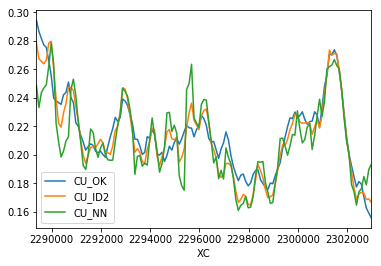

In [42]:
mymodel.bmtable.groupby('XC')[['CU_OK','CU_ID2','CU_NN']].mean().plot()

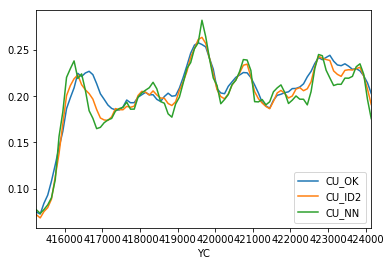

In [43]:
mymodel.bmtable.groupby('YC')[['CU_OK','CU_ID2','CU_NN']].mean().plot()

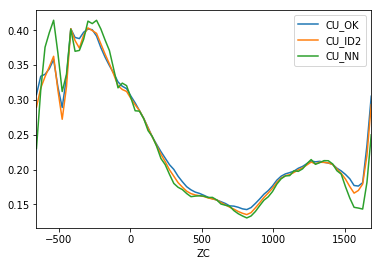

In [44]:
mymodel.bmtable.groupby('ZC')[['CU_OK','CU_ID2','CU_NN']].mean().plot()

### Global change of support

Raw Variance 0.109758094158
Variance from PCI 0.109226799954
zamin 0.0152055598867
zamax 15.3937427773
yamin -0.269053810762
yamax 4.23184636927
zpmin 0.00199999996
zpmax 15.398035249
ypmin -0.269053810762
ypmax 4.28185637127


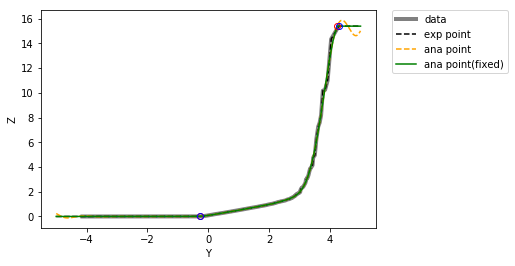

In [45]:
# Fit anamorphosis by changing, zmax, zmin, and extrapolation function
PCI, H, raw, zana, gauss, z, P, raw_var, PCI_var, fig1 = pygslib.nonlinear.anamor(
                         z = mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'], 
                         w = mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'declustwt'], 
                         zmin = mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'].min(), 
                         zmax = mydholedb.table["CMP"].loc[mydholedb.table['CMP']['Domain']==1, 'CU'].max(),
                         zpmin = None, zpmax = None,
                         ymin=-5, ymax=5,
                         ndisc = 5000,
                         ltail=1, utail=4, ltpar=1, utpar=1.5, K=40)



In [46]:
# calculate the support correction coefficient r
r = pygslib.nonlinear.get_r(Var_Zv = cbb, PCI = PCI)

print 'cbb :', cbb
print 'r   :', r

cbb : 0.0310319369002
r   : 0.619257219183


Note that r is very low... 

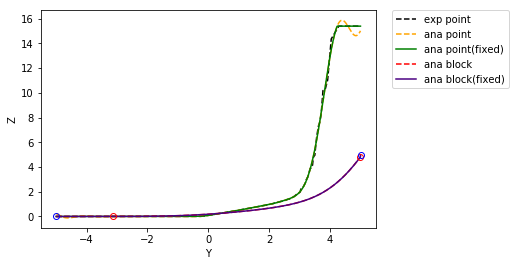

In [47]:
# fit block anamorphosis
ZV, PV, fig2 = pygslib.nonlinear.anamor_blk( PCI, H, r = r, gauss = gauss, Z = z,
                  ltail=1, utail=1, ltpar=1, utpar=1,
                  raw=raw, zana=zana)

In [48]:
cutoff = np.arange(0,0.6, 0.01)
tt = []
gg = []
label = []

# calculate GTC from gaussian in block support 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=ZV, p=PV, varred = 1, ivtyp = 0, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('DGM with block support')


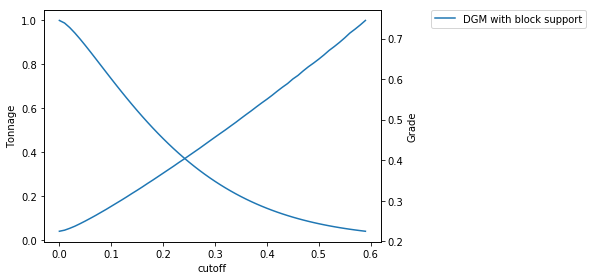

In [49]:
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

In [50]:
# to compare global resources with the one estimated we calculate the CDF of the blocks

# cdf of kriging estimate
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['CU_OK'][mymodel.bmtable['CU_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['CU_OK'][mymodel.bmtable['CU_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)


binval_ok,cl_ok,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)

# cdf of id2
parameters_probplt = {
        'iwt'  : 0,                             #int, 1 use declustering weight
        'va'   : mymodel.bmtable['CU_ID2'][mymodel.bmtable['CU_OK'].notnull()].values,             # array('d') with bounds (nd)
        'wt'   : np.ones(mymodel.bmtable['CU_OK'][mymodel.bmtable['CU_OK'].notnull()].shape[0])} # array('d') with bounds (nd), wight variable (obtained with declust?)

binval_id2,cl_id2,xpt025,xlqt,xmed,xuqt,xpt975,xmin,xmax, \
xcvr,xmen,xvar,error = pygslib.gslib.__plot.probplt(**parameters_probplt)



In [51]:
# calculate GTC ok 
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_ok, p=binval_ok, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Ordinary Kriging')

# calculate GTC in block support
t,ga,gb = pygslib.nonlinear.gtcurve (cutoff = cutoff, z=cl_id2, p=binval_id2, varred = 1, ivtyp = 2, zmin = 0, zmax = None,
             ltail = 1, ltpar = 1, middle = 1, mpar = 1, utail = 1, utpar = 1,maxdis = 1000)
tt.append(t)
gg.append(ga)
label.append('Inverse of the Distance 2)')

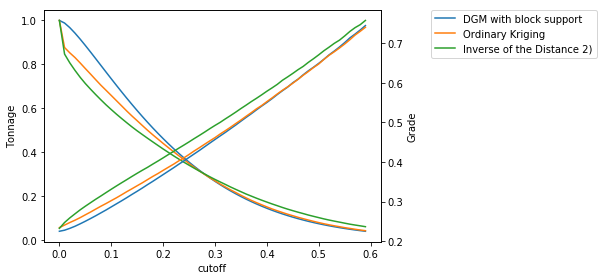

In [52]:
fig = pygslib.nonlinear.plotgt(cutoff = cutoff, t = tt, g = gg, label = label)

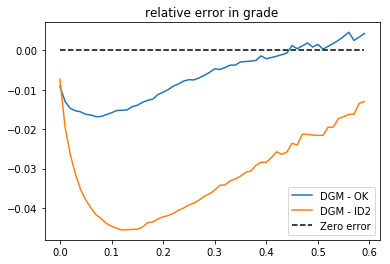

In [53]:
# we can plot diferences (relative error in grade)

plt.plot (cutoff, gg[0]-gg[1], label = 'DGM - OK')
plt.plot (cutoff, gg[0]-gg[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.title('relative error in grade')
plt.legend()

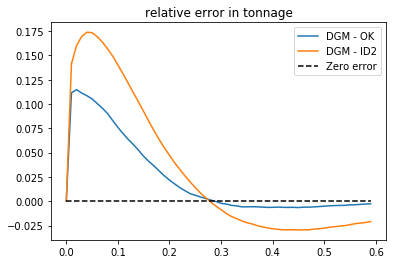

In [54]:
# we can plot diferences (relative error in tonnage)

plt.plot (cutoff, tt[0]-tt[1], label = 'DGM - OK')
plt.plot (cutoff, tt[0]-tt[2], label = 'DGM - ID2')
plt.plot (cutoff, np.zeros(cutoff.shape[0]),'--k', label = 'Zero error')
plt.legend()
plt.title('relative error in tonnage')

In [55]:
# To get tonnes right just multiply per total tonnes

# calcullate tottal tonnage (million tonnes)
ttonnes = mymodel.bmtable['D1'][mymodel.bmtable['CU_OK'].notnull()].sum()*100*100*30* 0.0283168 * 2.7 /1000000 
# cubic foot to m -> 0.0283168, density 2.7

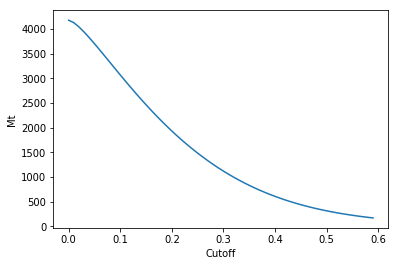

In [56]:
ttt = tt[0]*ttonnes

#plot
plt.plot(cutoff, ttt)
plt.ylabel('Mt')
plt.xlabel('Cutoff')